In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class DeepConvLSTM(nn.Module):
    def __init__(self, nc_input, n_classes):
        super(DeepConvLSTM, self).__init__()
        self.hidden_dim = 128

        self.conv1 = nn.Conv1d(nc_input, 64, 5)
        self.conv2 = nn.Conv1d(64, 64, 5)
        self.conv3 = nn.Conv1d(64, 64, 5)
        self.conv4 = nn.Conv1d(64, 64, 5)

        self.lstm_cell1 = nn.LSTMCell(input_size=64, hidden_size=128)
        self.lstm_cell2 = nn.LSTMCell(input_size=128, hidden_size=128)

        #self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, batch_first=True)
        
        self.fc = nn.Linear(128, n_classes)

        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        hx = torch.randn(x.size(0), self.hidden_dim, device=x.device)
        cx = torch.randn(x.size(0), self.hidden_dim, device=x.device)
        output = []
        for t in range(x.size(2)):
            hx, cx = self.lstm_cell1(x[:,:,t], (hx,cx))
            output.append(hx)

        x = torch.stack(output, dim=2)

        hx = torch.randn(x.size(0), self.hidden_dim, device=x.device)
        cx = torch.randn(x.size(0), self.hidden_dim, device=x.device)
        output = []
        for t in range(x.size(2)):
            hx,cx = self.lstm_cell2(x[:,:,t], (hx,cx))
            output.append(hx)
        h = output[-1].squeeze()

        #x = torch.transpose(x, 1, 2)
        #x,(h, c) = self.lstm(x)

        #h = h[-1,:,:]
        h = self.dropout(h)
        logits = self.fc(h)

        return logits

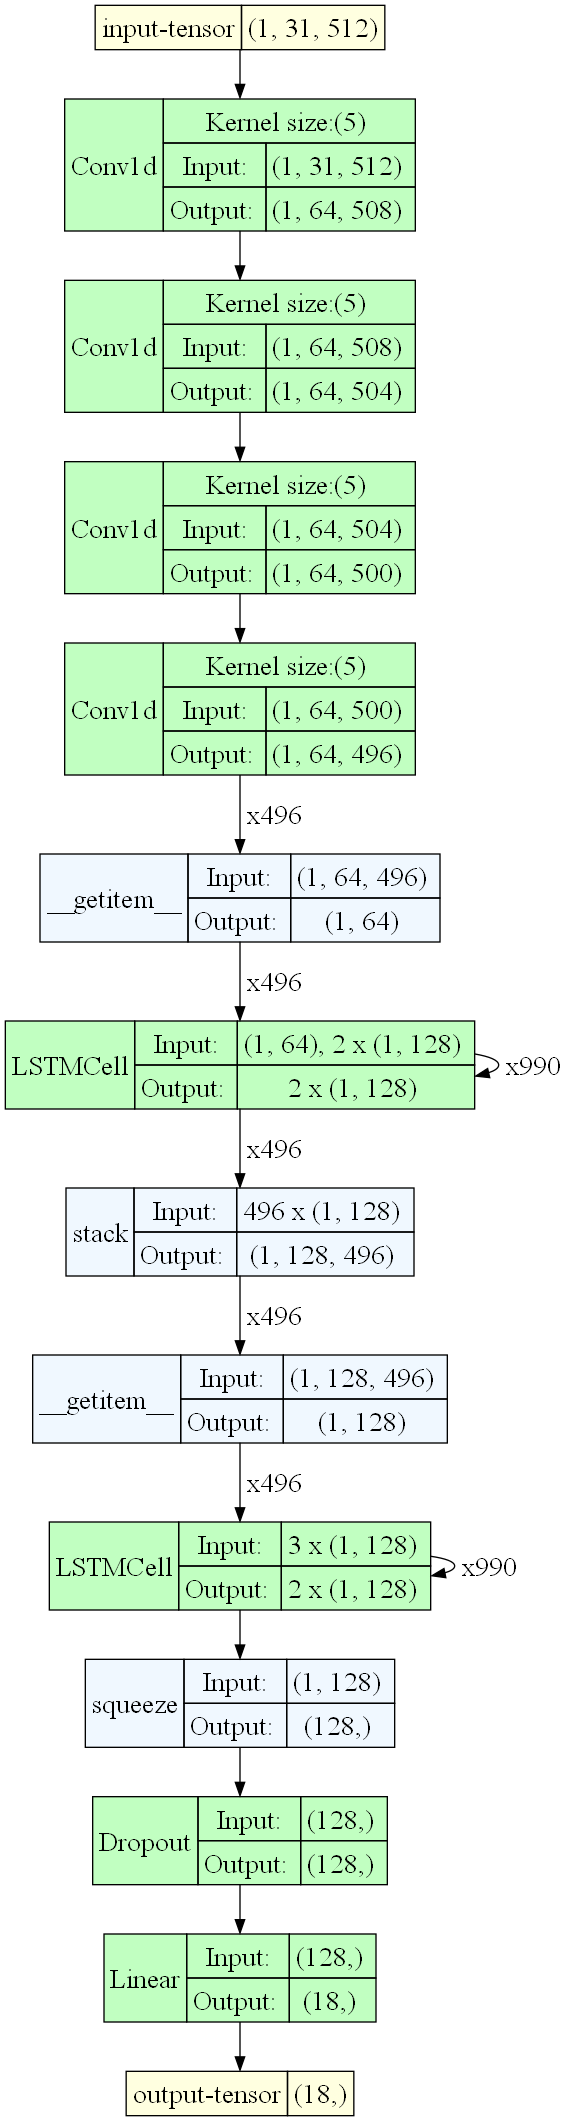

In [2]:
from utils import data_info
# import os
# os.environ["PATH"]+=os.pathsep+'C:\\Program Files\\Graphviz\\bin'
import graphviz
graphviz.set_jupyter_format('png')

#dataset = "UCI_HAR"
#dataset = "UniMiB-SHAR"
#dataset = "OPPORTUNITY"
dataset = "PAMAP2"
#dataset = "DSADS"
#dataset = "KU-HAR"
#dataset = "REALDISP"


input_nc, segment_size, class_num = data_info(dataset)

net = DeepConvLSTM(input_nc, class_num)

from torchview import draw_graph

model_graph = draw_graph(net, input_size=(1, input_nc, segment_size), save_graph=True, filename="DeepConvLSTM", expand_nested=False, roll=True)
model_graph.visual_graph